In [1]:
 import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [80]:
data = pd.read_csv("new_data.csv")

In [81]:
# display(data[data['Project Number'] == "5098-68726"])
# display(data[data['Project Number'] == "2012-457386-SLPR"])

| Column name| Description                                   |
| ------------- | --------------------------------------------- |
Project Number	| Unique identifier for each project. (Number)
City	|The city where the project is located. (Text)
County	|The county where the project is located. (Text)
Zip Code|	The zip code of the project location. (Number)
Program Type	|The type of program the project is associated with. (Text)
Solicitation	|The solicitation the project is associated with. (Text)
Electric Utility|	The electric utility associated with the project. (Text)
Purchase Type|	The type of purchase associated with the project. (Text)
Date Application Received	| The date the application for the project was received. (Date)
Date Completed|	The date the project was completed. (Date)
Project Status	|The status of the project. (Text)
Contractor	| The contractor associated with the project. (Text)
Primary Inverter Manufacturer	|The primary inverter manufacturer associated with the project. (Text)
Total Inverter Quantity	|The total number of inverters associated with the project. (Number)
Primary PV Module Manufacturer|	The primary PV module manufacturer associated with the project. (Text)
Total PV Module Quantity	|The total number of PV modules associated with the project. (Number)
Project Cost	|The total cost of the project. (Number)
Incentive|	The total incentive amount associated with the project. (Number)
Total Nameplate kW DC|	The total nameplate capacity of the project in kW DC. (Number)
Expected KWh Annual Production|	The expected annual production of the project in KWh. (Number)
Affordable Solar| subsidized solar for lower income areas
Community Distributed Generation| subscribe to solar farm
Green Jobs Green New York Participant| new york incentive

# **Data Cleaning**

In [82]:
#removing spaces
data.columns=['ProjectNumber', 'City', 'County', 'ZipCode',
       'ProgramType', 'Solicitation', 'ElectricUtility', 'PurchaseType',
       'DateApplicationReceived', 'DateCompleted', 'ProjectStatus',
       'Contractor', 'PrimaryInverterManufacturer',
       'TotalInverterQuantity', 'PrimaryPVModuleManufacturer',
       'TotalPVModuleQuantity', 'ProjectCost', 'Incentive',
       'TotalNameplatekWDC', 'ExpectedKWhAnnualProduction',
       'AffordableSolar', 'CommunityDistributedGeneration',
       'GreenJobsGreenNewYorkParticipant']


In [83]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
# converting to date time and then creating a new column that give the duration of the project
data['DateApplicationReceived'] = pd.to_datetime(data.DateApplicationReceived)
data['DateCompleted'] = pd.to_datetime(data.DateCompleted)
data["duration"]= data.DateCompleted-data.DateApplicationReceived

In [85]:
# converting yes=1 no=0
data.loc[(data.AffordableSolar=="No"),"AffordableSolar"]=0
data.loc[(data.AffordableSolar=="Yes"),"AffordableSolar"]=1

data.loc[(data.CommunityDistributedGeneration=="No"),"CommunityDistributedGeneration"]=0
data.loc[(data.CommunityDistributedGeneration=="Yes"),"CommunityDistributedGeneration"]=1


In [86]:
data = data.loc[data.DateCompleted.dt.year!=2018]
data = data.loc[data.DateApplicationReceived.dt.year!=2018]
#getting rid of entries in 2018 since data was measured in February of that year,
#so it would skew data

In [87]:
#removing projects that were received after they were completed
data = data[data["duration"].dt.days > 0]

In [88]:
#removing industrial data because there is not enough and it is likely a confounding variable
data=data.loc[(data.ProgramType=="Residential/Small Commercial"),:]

In [89]:
#remove rows with missing values we will later use to predict Output
data = data[~data.Incentive.isnull()]
data = data[~data.ExpectedKWhAnnualProduction.isnull()]
data = data[~data.duration.isnull()]
data = data[~data.TotalPVModuleQuantity.isnull()]
data = data[~data.ProjectCost.isnull()]

In [90]:
#removing dollar sign from incentive and project cost
data["Incentive"] = data["Incentive"].str[1::1].astype(float)
data["ProjectCost"] = data["ProjectCost"].str[1::1].astype(float)

In [91]:
#removing ProjectStatus column because now all of them will be of "completed" status
data = data.drop(columns="ProjectStatus")

In [92]:
data.head()

,ProjectNumber,City,County,ZipCode,ProgramType,Solicitation,ElectricUtility,PurchaseType,DateApplicationReceived,DateCompleted,...,PrimaryPVModuleManufacturer,TotalPVModuleQuantity,ProjectCost,Incentive,TotalNameplatekWDC,ExpectedKWhAnnualProduction,AffordableSolar,CommunityDistributedGeneration,GreenJobsGreenNewYorkParticipant,duration
0,5137-49041,Maine,Broome,13802,Residential/Small Commercial,PON 2112,NYS Electric and Gas,Lease,2014-09-30,2015-01-14,...,Hyundai Heavy Industries,40.0,41800.00,6930.0,10.00,11738.0,0,0,NaN,106 days
1,5137-46019,Levittown,Nassau,11756,Residential/Small Commercial,PON 2112LI,PSEG Long Island,Lease,2014-09-02,2015-01-16,...,Hyundai Heavy Industries,28.0,30940.00,2520.0,7.00,8217.0,0,0,NaN,136 days
2,5137-52151,Cortland,Cortland,13045,Residential/Small Commercial,PON 2112,National Grid,Lease,2014-11-12,2015-01-29,...,Hyundai Heavy Industries,49.0,48387.50,11025.0,12.25,14380.0,0,0,NaN,78 days
3,5129-94109,Staten Island,Richmond,10314,Residential/Small Commercial,PON 2112,Consolidated Edison,Purchase,2016-03-24,2016-08-09,...,SunPower,15.0,23509.54,2943.0,4.91,5758.0,0,0,NaN,138 days
4,5137-46454,Warwick,Orange,10990,Residential/Small Commercial,PON 2112,Orange and Rockland Utilities,Lease,2014-08-28,2014-12-31,...,Hyundai Heavy Industries,22.0,25283.00,5720.0,5.72,6714.0,0,0,NaN,125 days


,ProjectNumber,City,County,ZipCode,ProgramType,Solicitation,ElectricUtility,PurchaseType,DateApplicationReceived,DateCompleted,...,PrimaryPVModuleManufacturer,TotalPVModuleQuantity,ProjectCost,Incentive,TotalNameplatekWDC,ExpectedKWhAnnualProduction,AffordableSolar,CommunityDistributedGeneration,GreenJobsGreenNewYorkParticipant,duration
0,5137-49041,Maine,Broome,13802,Residential/Small Commercial,PON 2112,NYS Electric and Gas,Lease,2014-09-30,2015-01-14,...,Hyundai Heavy Industries,40.0,41800.00,6930.0,10.00,11738.0,0,0,NaN,106 days
1,5137-46019,Levittown,Nassau,11756,Residential/Small Commercial,PON 2112LI,PSEG Long Island,Lease,2014-09-02,2015-01-16,...,Hyundai Heavy Industries,28.0,30940.00,2520.0,7.00,8217.0,0,0,NaN,136 days
2,5137-52151,Cortland,Cortland,13045,Residential/Small Commercial,PON 2112,National Grid,Lease,2014-11-12,2015-01-29,...,Hyundai Heavy Industries,49.0,48387.50,11025.0,12.25,14380.0,0,0,NaN,78 days
3,5129-94109,Staten Island,Richmond,10314,Residential/Small Commercial,PON 2112,Consolidated Edison,Purchase,2016-03-24,2016-08-09,...,SunPower,15.0,23509.54,2943.0,4.91,5758.0,0,0,NaN,138 days
4,5137-46454,Warwick,Orange,10990,Residential/Small Commercial,PON 2112,Orange and Rockland Utilities,Lease,2014-08-28,2014-12-31,...,Hyundai Heavy Industries,22.0,25283.00,5720.0,5.72,6714.0,0,0,NaN,125 days


# **Exploratory data analysis EDA**

In [93]:
DataEx = data.copy()

In [94]:
DataEx.columns

Index(['ProjectNumber', 'City', 'County', 'ZipCode', 'ProgramType',
       'Solicitation', 'ElectricUtility', 'PurchaseType',
       'DateApplicationReceived', 'DateCompleted', 'Contractor',
       'PrimaryInverterManufacturer', 'TotalInverterQuantity',
       'PrimaryPVModuleManufacturer', 'TotalPVModuleQuantity', 'ProjectCost',
       'Incentive', 'TotalNameplatekWDC', 'ExpectedKWhAnnualProduction',
       'AffordableSolar', 'CommunityDistributedGeneration',
       'GreenJobsGreenNewYorkParticipant', 'duration'],
      dtype='object')

Index(['ProjectNumber', 'City', 'County', 'ZipCode', 'ProgramType',
       'Solicitation', 'ElectricUtility', 'PurchaseType',
       'DateApplicationReceived', 'DateCompleted', 'Contractor',
       'PrimaryInverterManufacturer', 'TotalInverterQuantity',
       'PrimaryPVModuleManufacturer', 'TotalPVModuleQuantity', 'ProjectCost',
       'Incentive', 'TotalNameplatekWDC', 'ExpectedKWhAnnualProduction',
       'AffordableSolar', 'CommunityDistributedGeneration',
       'GreenJobsGreenNewYorkParticipant', 'duration'],
      dtype='object')

In [95]:
#DataEx.shape()

In [96]:
#summary of quantities
DataEx[["TotalInverterQuantity","TotalPVModuleQuantity",
"TotalNameplatekWDC","ExpectedKWhAnnualProduction"]].describe()

,TotalInverterQuantity,TotalPVModuleQuantity,TotalNameplatekWDC,ExpectedKWhAnnualProduction
count,74107.000000,74126.000000,74126.000000,7.412600e+04
mean,8.168810,36.378302,9.738624,1.143073e+04
std,15.272647,62.670513,17.098380,2.007083e+04
min,1.000000,1.000000,0.250000,2.930000e+02
25%,1.000000,19.000000,5.200000,6.104000e+03
50%,1.000000,26.000000,7.140000,8.381000e+03
75%,11.000000,36.000000,9.880000,1.159800e+04
max,800.000000,3770.000000,1021.440000,1.199007e+06


,TotalInverterQuantity,TotalPVModuleQuantity,TotalNameplatekWDC,ExpectedKWhAnnualProduction
count,74107.000000,74126.000000,74126.000000,7.412600e+04
mean,8.168810,36.378302,9.738624,1.143073e+04
std,15.272647,62.670513,17.098380,2.007083e+04
min,1.000000,1.000000,0.250000,2.930000e+02
25%,1.000000,19.000000,5.200000,6.104000e+03
50%,1.000000,26.000000,7.140000,8.381000e+03
75%,11.000000,36.000000,9.880000,1.159800e+04
max,800.000000,3770.000000,1021.440000,1.199007e+06


In [97]:
#counties
county_duration = DataEx[["County","duration","Incentive",
"ProjectCost","ExpectedKWhAnnualProduction"]].\
rename(columns={"ExpectedKWhAnnualProduction":"ExpectedProduction(KWh)"}).\
groupby(DataEx.County) #grouping by county
keep_max = county_duration.max().drop(columns="County").reset_index()
keep_min = county_duration.min().drop(columns="County").reset_index()

In [98]:
#Counties with the highest duration, incentive, project cost, expected production
keep_max.set_index(["County"]).idxmax()

duration                   Rensselaer
Incentive                     Suffolk
ProjectCost                   Suffolk
ExpectedProduction(KWh)       Suffolk
dtype: object

duration                   Rensselaer
Incentive                     Suffolk
ProjectCost                   Suffolk
ExpectedProduction(KWh)       Suffolk
dtype: object

In [99]:
#Counties with the lowest duration, incentive, project cost, expected production
keep_min.set_index(["County"]).idxmin()

duration                      Kings
Incentive                    Nassau
ProjectCost                  Albany
ExpectedProduction(KWh)    Tompkins
dtype: object

duration                      Kings
Incentive                    Nassau
ProjectCost                  Albany
ExpectedProduction(KWh)    Tompkins
dtype: object

In [100]:
#how incentives have changed over the years
sub = pd.DataFrame({"Year": DataEx.DateCompleted, "Incentive": DataEx.Incentive,
 "ProjectCost": DataEx.ProjectCost, "ExpectedProduction(kWh)": DataEx.ExpectedKWhAnnualProduction})
sub.Year = sub.Year.dt.year
sub_mean = sub.groupby(sub.Year).mean().reset_index()
sub_total = sub.groupby(sub.Year).sum().reset_index()

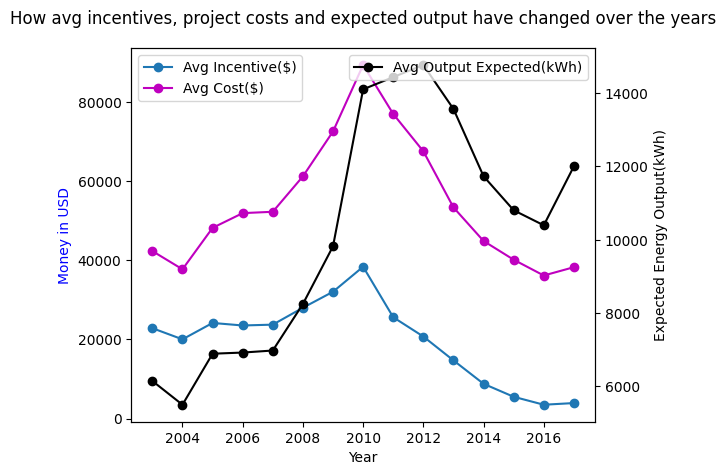

<Figure size 640x480 with 0 Axes>

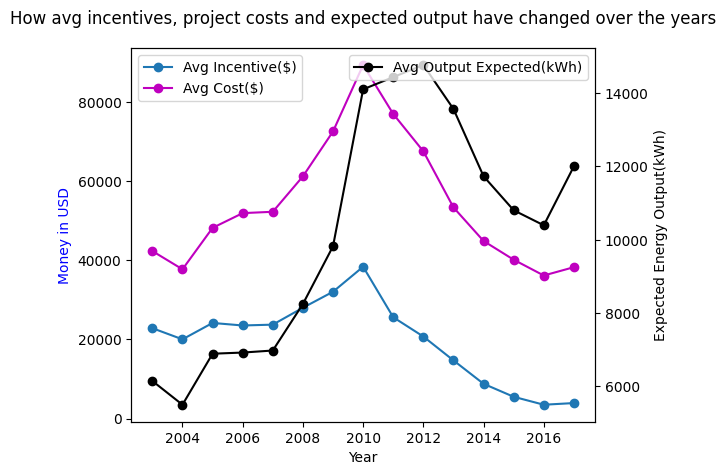

<Figure size 640x480 with 0 Axes>

In [101]:
#how incentives have changed over the years (mean)
fig, ax1 = plt.subplots(tight_layout = True)

ax1.plot(sub_mean.Year,sub_mean.Incentive, marker='o',label="Avg Incentive($)")
ax1.plot(sub_mean.Year, sub_mean.ProjectCost, marker='o', label="Avg Cost($)", c='m')
ax1.set_xlabel("Year")
ax1.set_ylabel("Money in USD", c='b')

ax2 = ax1.twinx()
ax2.plot(sub_mean.Year, sub_mean["ExpectedProduction(kWh)"],
marker='o', label="Avg Output Expected(kWh)", color='k')
ax2.set_ylabel("Expected Energy Output(kWh)", color='k')

fig.suptitle("How avg incentives, project costs and expected output have changed over the years")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()
plt.savefig("mean_cost_inc_out")

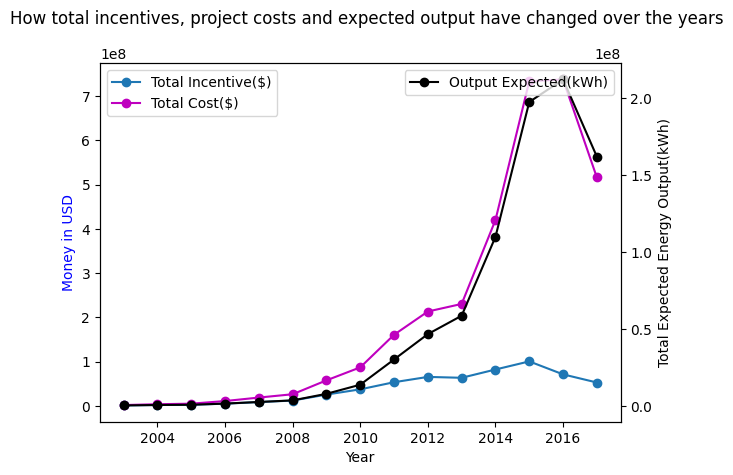

<Figure size 640x480 with 0 Axes>

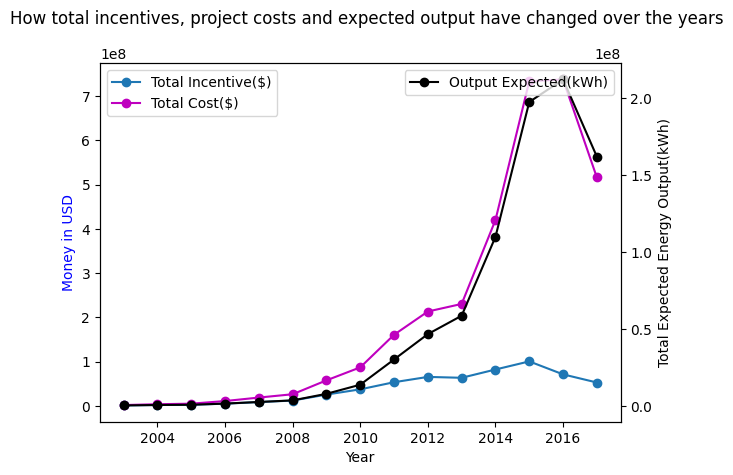

<Figure size 640x480 with 0 Axes>

In [102]:
#how incentives have changed over the years (total)
fig, ax1 = plt.subplots(tight_layout = True)

ax1.plot(sub_total.Year,sub_total.Incentive, marker='o',label="Total Incentive($)")
ax1.plot(sub_total.Year, sub_total.ProjectCost, marker='o', label="Total Cost($)", c='m')
ax1.set_xlabel("Year")
ax1.set_ylabel("Money in USD", c='b')

ax2 = ax1.twinx()
ax2.plot(sub_total.Year, sub_total["ExpectedProduction(kWh)"],
marker='o', label="Output Expected(kWh)", color='k')
ax2.set_ylabel("Total Expected Energy Output(kWh)", color='k')

fig.suptitle("How total incentives, project costs and expected output have changed over the years")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()
plt.savefig("total_cost_inc_out")

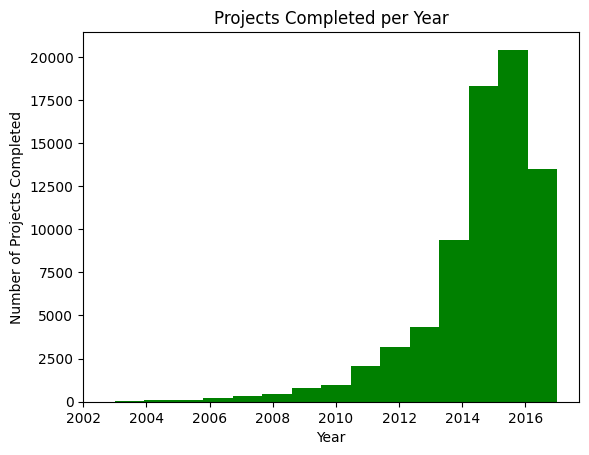

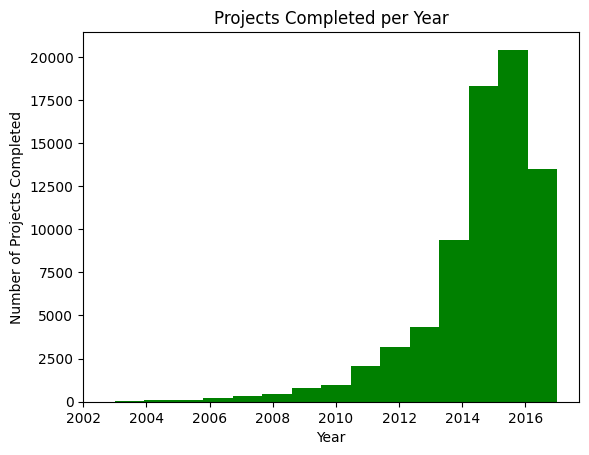

In [103]:
#how many projects are completed each year,
#axis shown with decimals but data is sorted by integer year
#shows a big acceleration in projects in 2013/2014
import numpy as np
plt.hist(DataEx.DateCompleted.dt.year, bins=15, color='green')
plt.xlabel("Year")
plt.ylabel("Number of Projects Completed")
plt.title("Projects Completed per Year")
plt.xticks(np.arange(2002, 2018, step=2))
plt.show()

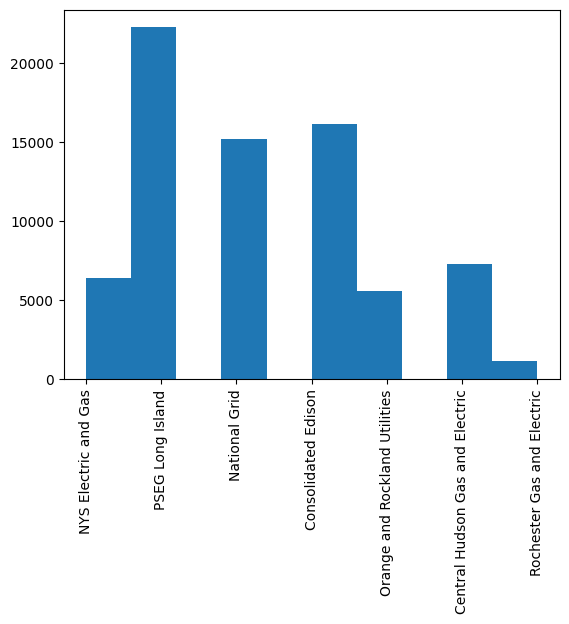

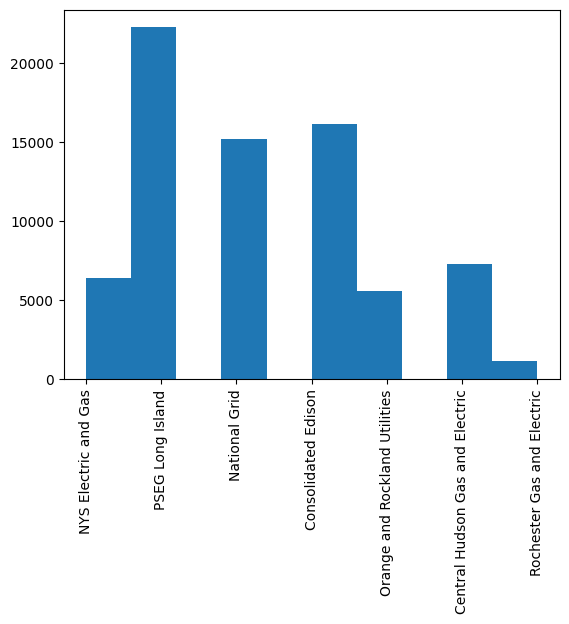

In [104]:
plt.hist(DataEx["ElectricUtility"])
plt.xticks(rotation ='vertical')
plt.show()

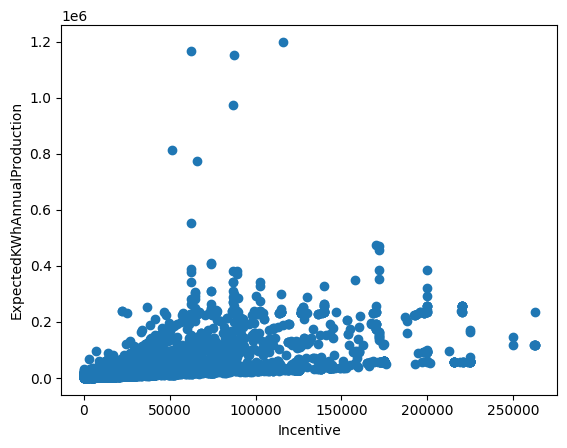

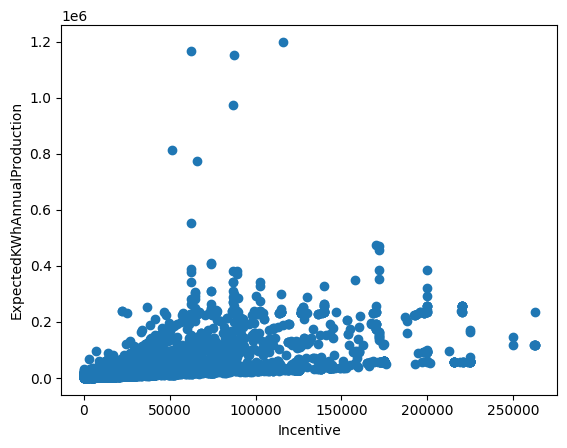

In [105]:
plt.scatter(data.Incentive,data.ExpectedKWhAnnualProduction)
plt.xlabel("Incentive")
plt.ylabel("ExpectedKWhAnnualProduction")
plt.show()

In [106]:
#graph showing duration vs incentive
sub = DataEx[["ProjectNumber","duration","ProjectCost","Incentive"]]
sub.groupby(DataEx.duration).nth([0,1,2])

,ProjectNumber,duration,ProjectCost,Incentive
duration,,,,
1 days,78547,1 days,16350.99,1077.0
1 days,68776,1 days,17827.00,1714.0
1 days,80476,1 days,12928.00,1224.0
2 days,80170,2 days,15470.00,1092.0
2 days,96188,2 days,64205.00,8750.0
...,...,...,...,...
1579 days,4183-002-1-NFI,1579 days,51230.00,15975.0
1583 days,4061-22567,1583 days,162190.00,49140.0
1648 days,02005-025,1648 days,28408.00,13200.0


,ProjectNumber,duration,ProjectCost,Incentive
duration,,,,
1 days,78547,1 days,16350.99,1077.0
1 days,68776,1 days,17827.00,1714.0
1 days,80476,1 days,12928.00,1224.0
2 days,80170,2 days,15470.00,1092.0
2 days,96188,2 days,64205.00,8750.0
...,...,...,...,...
1579 days,4183-002-1-NFI,1579 days,51230.00,15975.0
1583 days,4061-22567,1583 days,162190.00,49140.0
1648 days,02005-025,1648 days,28408.00,13200.0


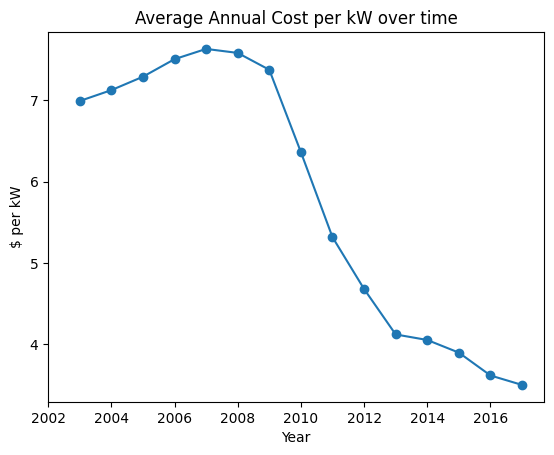

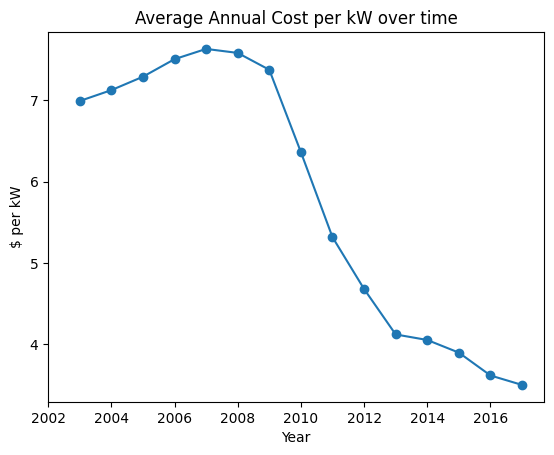

In [107]:
#showing how expensive solar construction is over time, trending down
DataEx['costperkW'] = DataEx.ProjectCost/DataEx.ExpectedKWhAnnualProduction
groupcost = DataEx.groupby(by=DataEx.DateCompleted.dt.year).costperkW
groupcost = groupcost.mean()
groupcost
plt.plot(groupcost.index, groupcost, marker='o')
plt.title('Average Annual Cost per kW over time')
plt.xlabel('Year')
plt.ylabel('$ per kW')
plt.xticks(np.arange(2002, 2018, step=2))
plt.show()

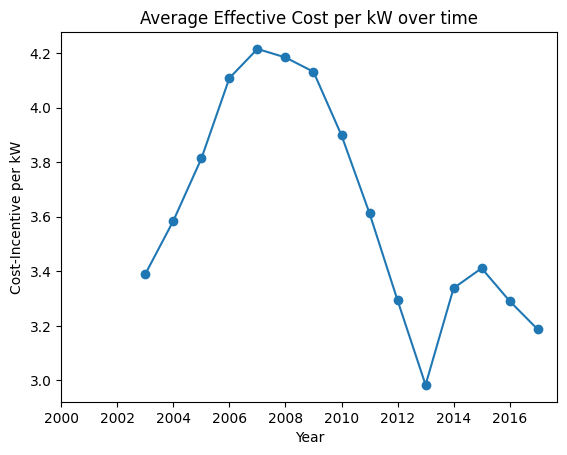

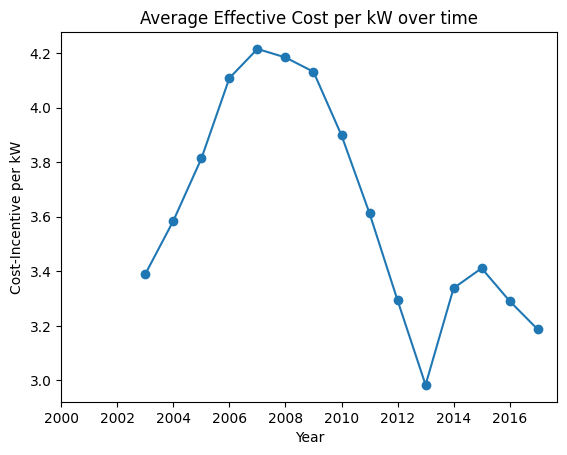

In [108]:
#plotting average effective cost(project cost- incentive) over time
DataEx['effcostperkW'] = (DataEx.ProjectCost-DataEx.Incentive)/DataEx.ExpectedKWhAnnualProduction
groupcost = DataEx.groupby(by=DataEx.DateCompleted.dt.year).effcostperkW
groupcost = groupcost.mean()
groupcost
plt.plot(groupcost.index, groupcost, marker='o')
plt.title('Average Effective Cost per kW over time')
plt.xlabel('Year')
plt.ylabel('Cost-Incentive per kW')
plt.xticks(np.arange(2000, 2018, step=2))
plt.show()

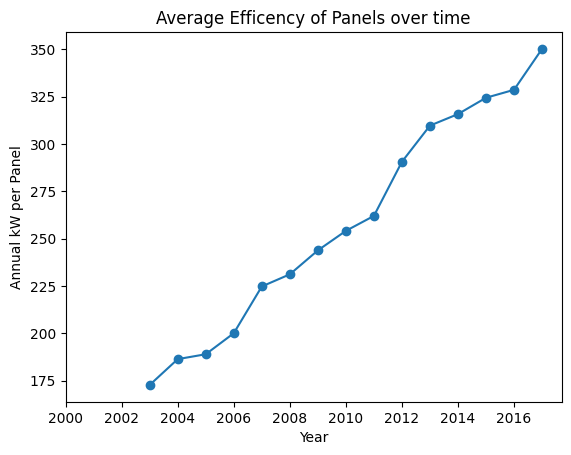

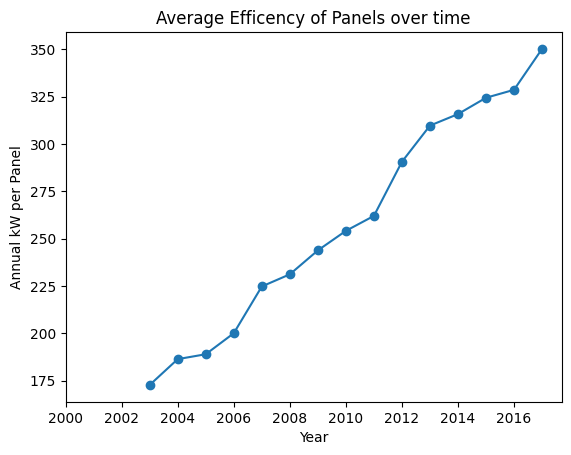

In [109]:
#looking at the energy efficency of solar panels installed
DataEx['efficiency'] = DataEx.ExpectedKWhAnnualProduction/DataEx.TotalPVModuleQuantity
groupcost = DataEx.groupby(by=DataEx.DateCompleted.dt.year).efficiency
groupcost = groupcost.mean()
groupcost
plt.plot(groupcost.index, groupcost, marker='o')
plt.title('Average Efficency of Panels over time')
plt.xlabel('Year')
plt.ylabel('Annual kW per Panel')
plt.xticks(np.arange(2000, 2018, step=2))
plt.show()

In [110]:
DataEx.duration.dt.days.max()

1769

1769

Text(0, 0.5, 'Out of Pocket costs ($) excluding outliers')

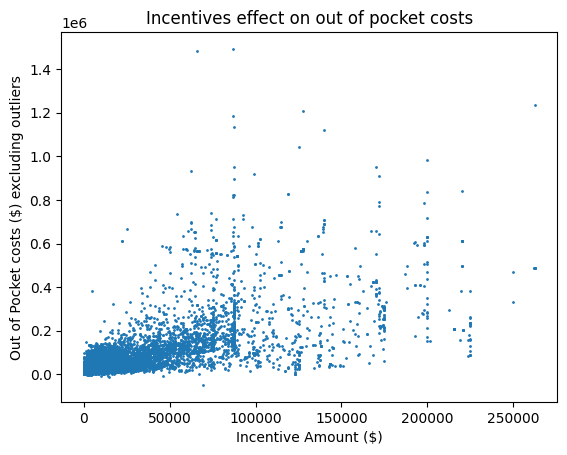

Text(0, 0.5, 'Out of Pocket costs ($) excluding outliers')

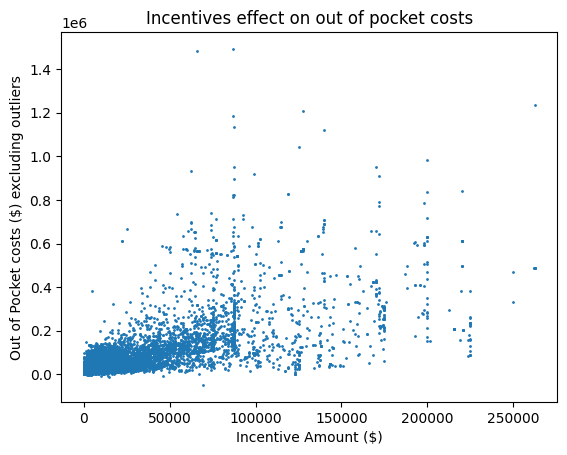

In [111]:
#Incentive vs (cost-incentive)
#(does incentive increase the amount companies are willing to invest out of pocket for the project?)
DataEx["OutofPocket"] = DataEx["ProjectCost"] - DataEx["Incentive"] #cost of project - incentive
Smaller_oop = DataEx.loc[DataEx["OutofPocket"] < 1.5E6]
plt.scatter(Smaller_oop["Incentive"], Smaller_oop["OutofPocket"],s=1)
plt.title("Incentives effect on out of pocket costs")
plt.xlabel("Incentive Amount ($)")
plt.ylabel("Out of Pocket costs ($) excluding outliers")

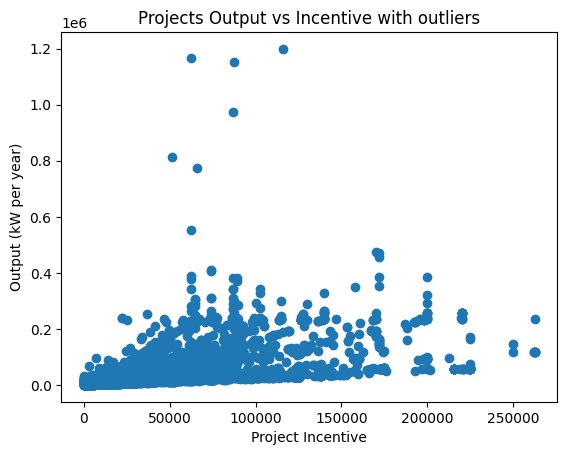

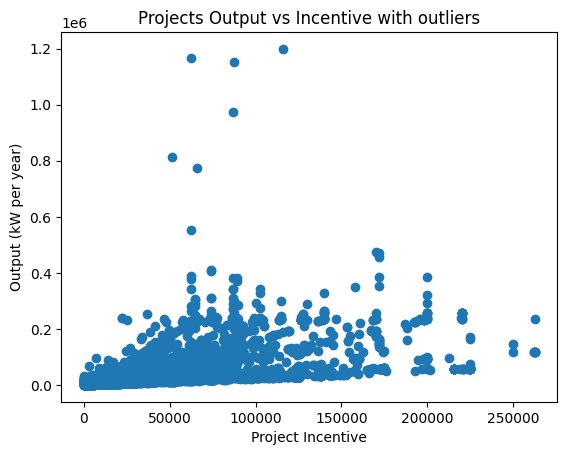

In [112]:
#visualizing relationship between output of projects and their incentives
plt.scatter(DataEx.Incentive, DataEx.ExpectedKWhAnnualProduction)
plt.title('Projects Output vs Incentive with outliers')
plt.ylabel('Output (kW per year)')
plt.xlabel('Project Incentive')
plt.show() #maybe not saying anything new

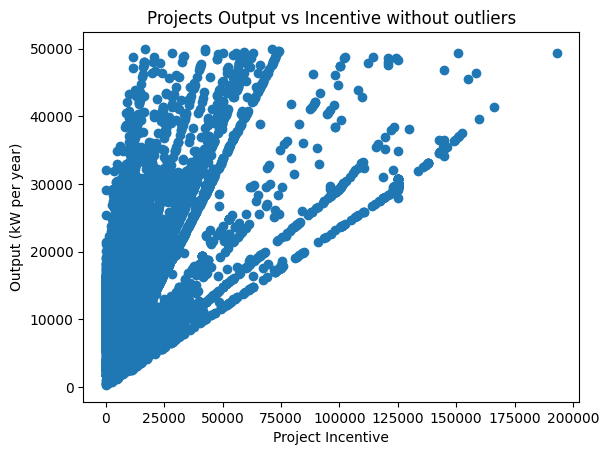

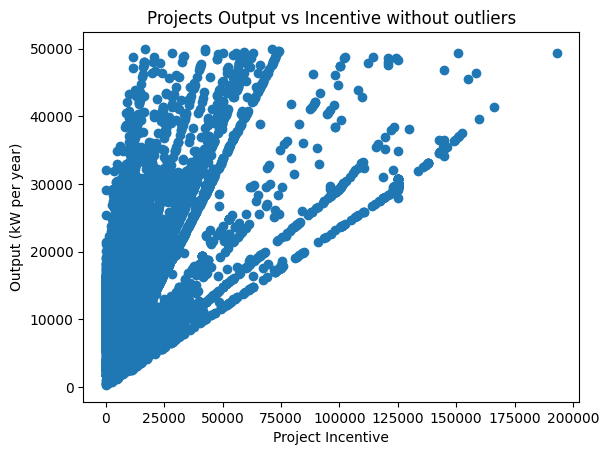

In [113]:
#visualizing relationship between output of projects and their incentives
smalloutput = DataEx.loc[DataEx.ExpectedKWhAnnualProduction<50000] #eliminating outliers to better visualize
plt.scatter(smalloutput.Incentive, smalloutput.ExpectedKWhAnnualProduction)
plt.title('Projects Output vs Incentive without outliers')
plt.ylabel('Output (kW per year)')
plt.xlabel('Project Incentive')
plt.show()

In [114]:
# cost/kwh vs incentive
DataEx2= DataEx.loc[DataEx.efficiency<600,:].groupby(by=DataEx.DateCompleted.dt.year).mean()
CKI_results=ols("efficiency~Incentive",DataEx2).fit()
CKI_results.params


<ipython-input-36-4f2f18e74532>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DataEx2= DataEx.loc[DataEx.efficiency<600,:].groupby(by=DataEx.DateCompleted.dt.year).mean()


Intercept    331.587058
Incentive     -0.003729
dtype: float64

<ipython-input-114-4f2f18e74532>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DataEx2= DataEx.loc[DataEx.efficiency<600,:].groupby(by=DataEx.DateCompleted.dt.year).mean()


Intercept    331.587058
Incentive     -0.003729
dtype: float64

Text(0.5, 1.0, 'Does Incentive Correlate with Efficiency?')

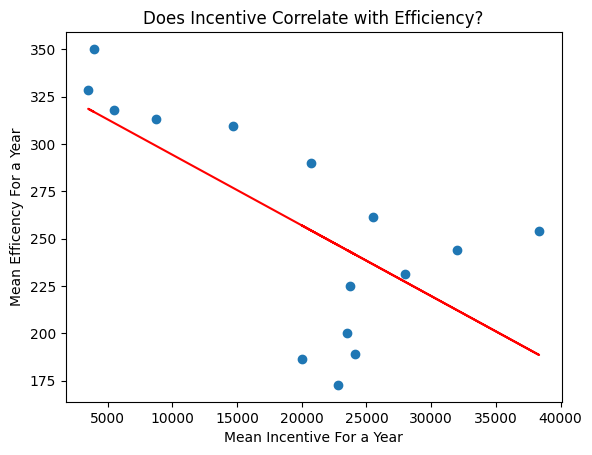

Text(0.5, 1.0, 'Does Incentive Correlate with Efficiency?')

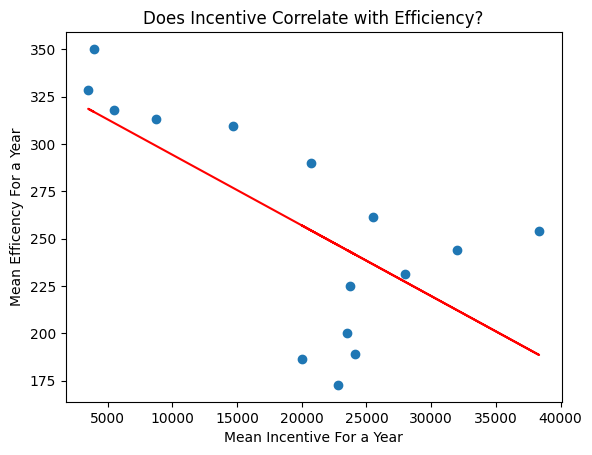

In [115]:
efficiency=331.588366-0.003729*(DataEx2.Incentive)
plt.plot(DataEx2.Incentive,efficiency,color='red')
plt.scatter(DataEx2.Incentive,DataEx2.efficiency)
plt.xlabel("Mean Incentive For a Year")
plt.ylabel("Mean Efficency For a Year")
plt.title("Does Incentive Correlate with Efficiency?")

# Predictive Analysis


In [116]:
#converted duration from datetime to number of days
DataEx['duration'] = DataEx.duration.dt.days

In [117]:
#seeing if any variables we use to predict Output are dependent on each other
pd.DataFrame(DataEx.corr().loc["ExpectedKWhAnnualProduction",["TotalPVModuleQuantity","ProjectCost","Incentive","duration"]])

<ipython-input-39-55fb6cbf982c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.DataFrame(DataEx.corr().loc["ExpectedKWhAnnualProduction",["TotalPVModuleQuantity","ProjectCost","Incentive","duration"]])


,ExpectedKWhAnnualProduction
TotalPVModuleQuantity,0.951046
ProjectCost,0.900064
Incentive,0.634686
duration,0.203408


<ipython-input-117-55fb6cbf982c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.DataFrame(DataEx.corr().loc["ExpectedKWhAnnualProduction",["TotalPVModuleQuantity","ProjectCost","Incentive","duration"]])


,ExpectedKWhAnnualProduction
TotalPVModuleQuantity,0.951046
ProjectCost,0.900064
Incentive,0.634686
duration,0.203408


In [118]:
#creating time variable as the year each project is completed to be used as a predictor later
firsttime = '2003-1-1 00:00:00'
starttime = pd.to_datetime(firsttime)
DataEx['t'] = DataEx.DateCompleted.dt.year.astype(int)
DataEx.t

0        2015
1        2015
2        2015
3        2016
4        2014
         ... 
84716    2015
84717    2014
84718    2016
84719    2015
84720    2016
Name: t, Length: 74126, dtype: int64

0        2015
1        2015
2        2015
3        2016
4        2014
         ... 
84716    2015
84717    2014
84718    2016
84719    2015
84720    2016
Name: t, Length: 74126, dtype: int64

In [119]:
#groupby year and found the average output for each year, then shifted them down a year so we could use last year's output
#as a predictor for this year (2016 projects would have the average output from 2015 in this column)
grouped = DataEx.groupby(by='t')
avgannualoutput = pd.DataFrame(grouped.ExpectedKWhAnnualProduction.mean())
avgannualoutput

,ExpectedKWhAnnualProduction
t,
2003,6149.162791
2004,5500.918367
2005,6891.852941
2006,6923.623810
2007,6979.077994
2008,8248.174825
2009,9820.474214
2010,14100.159138
2011,14433.691092


,ExpectedKWhAnnualProduction
t,
2003,6149.162791
2004,5500.918367
2005,6891.852941
2006,6923.623810
2007,6979.077994
2008,8248.174825
2009,9820.474214
2010,14100.159138
2011,14433.691092


In [120]:
prevavgannualoutput = avgannualoutput.shift()
prevavgannualoutput.columns = ['previousyearavgoutput']
DataEx = pd.merge(DataEx, prevavgannualoutput, on="t", how="left")
DataEx

,ProjectNumber,City,County,ZipCode,ProgramType,Solicitation,ElectricUtility,PurchaseType,DateApplicationReceived,DateCompleted,...,AffordableSolar,CommunityDistributedGeneration,GreenJobsGreenNewYorkParticipant,duration,costperkW,effcostperkW,efficiency,OutofPocket,t,previousyearavgoutput
0,5137-49041,Maine,Broome,13802,Residential/Small Commercial,PON 2112,NYS Electric and Gas,Lease,2014-09-30,2015-01-14,...,0,0,NaN,106,3.561084,2.970693,293.450000,34870.00,2015,11729.945210
1,5137-46019,Levittown,Nassau,11756,Residential/Small Commercial,PON 2112LI,PSEG Long Island,Lease,2014-09-02,2015-01-16,...,0,0,NaN,136,3.765364,3.458683,293.464286,28420.00,2015,11729.945210
2,5137-52151,Cortland,Cortland,13045,Residential/Small Commercial,PON 2112,National Grid,Lease,2014-11-12,2015-01-29,...,0,0,NaN,78,3.364917,2.598227,293.469388,37362.50,2015,11729.945210
3,5129-94109,Staten Island,Richmond,10314,Residential/Small Commercial,PON 2112,Consolidated Edison,Purchase,2016-03-24,2016-08-09,...,0,0,NaN,138,4.082935,3.571820,383.866667,20566.54,2016,10803.467261
4,5137-46454,Warwick,Orange,10990,Residential/Small Commercial,PON 2112,Orange and Rockland Utilities,Lease,2014-08-28,2014-12-31,...,0,0,NaN,125,3.765713,2.913762,305.181818,19563.00,2014,13564.893701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74121,5105-47036,Rye,Westchester,10580,Residential/Small Commercial,PON 2112,Consolidated Edison,Power Purchase Agreement,2014-09-08,2015-03-05,...,0,0,NaN,178,3.553521,2.951597,293.470588,29451.03,2015,11729.945210
74122,5105-46445,New Windsor,Orange,12553,Residential/Small Commercial,PON 2112,Consolidated Edison,Power Purchase Agreement,2014-08-28,2014-11-06,...,0,0,NaN,70,3.281493,2.429592,293.461538,18537.79,2014,13564.893701
74123,5121-99651,Manlius,Onondaga,13104,Residential/Small Commercial,PON 2112,National Grid,Purchase,2016-06-10,2016-08-10,...,0,0,NaN,61,3.005949,2.665186,311.066667,24871.52,2016,10803.467261
74124,5114-54501,Staten Island,Richmond,10306,Residential/Small Commercial,PON 2112,Consolidated Edison,Lease,2014-12-10,2015-10-13,...,0,0,NaN,307,3.149836,2.399166,305.181818,16108.00,2015,11729.945210


,ProjectNumber,City,County,ZipCode,ProgramType,Solicitation,ElectricUtility,PurchaseType,DateApplicationReceived,DateCompleted,...,AffordableSolar,CommunityDistributedGeneration,GreenJobsGreenNewYorkParticipant,duration,costperkW,effcostperkW,efficiency,OutofPocket,t,previousyearavgoutput
0,5137-49041,Maine,Broome,13802,Residential/Small Commercial,PON 2112,NYS Electric and Gas,Lease,2014-09-30,2015-01-14,...,0,0,NaN,106,3.561084,2.970693,293.450000,34870.00,2015,11729.945210
1,5137-46019,Levittown,Nassau,11756,Residential/Small Commercial,PON 2112LI,PSEG Long Island,Lease,2014-09-02,2015-01-16,...,0,0,NaN,136,3.765364,3.458683,293.464286,28420.00,2015,11729.945210
2,5137-52151,Cortland,Cortland,13045,Residential/Small Commercial,PON 2112,National Grid,Lease,2014-11-12,2015-01-29,...,0,0,NaN,78,3.364917,2.598227,293.469388,37362.50,2015,11729.945210
3,5129-94109,Staten Island,Richmond,10314,Residential/Small Commercial,PON 2112,Consolidated Edison,Purchase,2016-03-24,2016-08-09,...,0,0,NaN,138,4.082935,3.571820,383.866667,20566.54,2016,10803.467261
4,5137-46454,Warwick,Orange,10990,Residential/Small Commercial,PON 2112,Orange and Rockland Utilities,Lease,2014-08-28,2014-12-31,...,0,0,NaN,125,3.765713,2.913762,305.181818,19563.00,2014,13564.893701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74121,5105-47036,Rye,Westchester,10580,Residential/Small Commercial,PON 2112,Consolidated Edison,Power Purchase Agreement,2014-09-08,2015-03-05,...,0,0,NaN,178,3.553521,2.951597,293.470588,29451.03,2015,11729.945210
74122,5105-46445,New Windsor,Orange,12553,Residential/Small Commercial,PON 2112,Consolidated Edison,Power Purchase Agreement,2014-08-28,2014-11-06,...,0,0,NaN,70,3.281493,2.429592,293.461538,18537.79,2014,13564.893701
74123,5121-99651,Manlius,Onondaga,13104,Residential/Small Commercial,PON 2112,National Grid,Purchase,2016-06-10,2016-08-10,...,0,0,NaN,61,3.005949,2.665186,311.066667,24871.52,2016,10803.467261
74124,5114-54501,Staten Island,Richmond,10306,Residential/Small Commercial,PON 2112,Consolidated Edison,Lease,2014-12-10,2015-10-13,...,0,0,NaN,307,3.149836,2.399166,305.181818,16108.00,2015,11729.945210


In [121]:
#our training set includes all years before and including 2015 and we use 2016 and 2017 as our test set to see how good our model is
train = DataEx.loc[(DataEx["t"]<= 2015)]
test = DataEx.loc[DataEx["t"]>2015]

model1 = ols("ExpectedKWhAnnualProduction~duration+Incentive+ProjectCost+TotalPVModuleQuantity+previousyearavgoutput", train).fit()
model1.params

Intercept               -2842.092957
duration                   -2.859735
Incentive                  -0.061599
ProjectCost                 0.098877
TotalPVModuleQuantity     192.155886
previousyearavgoutput       0.269916
dtype: float64

Intercept               -2842.092957
duration                   -2.859735
Incentive                  -0.061599
ProjectCost                 0.098877
TotalPVModuleQuantity     192.155886
previousyearavgoutput       0.269916
dtype: float64

In [122]:
mainintercept, beta_duration, beta_incentive, beta_cost, beta_pv, beta_previous = model1.params
model1.conf_int(0.05)
#beta_duration represents for every additional day, the expected kwh annual production will increase by -2.859735 given all other factors remain constant
#beta_incentive represents for every additional dollar, the expected kwh annual production will decrease by -0.061599 given all other factors remain constant
#beta_cost represents for every additional dollar, the expected kwh annual production will increase by 0.098877 given all other factors remain constant
#beta_pv represents for every additional module, the expected kwh annual production will increase by 192.155886 given all other factors remain constant
#beta_previous represents for every additional output in the previous year, the expected kwh annual production in the current year will incease by 0.269916  given all other factors remain constant
#confidence intervals show that all variables are significant since the signs are the same

,0,1
Intercept,-3289.134101,-2395.051812
duration,-3.349720,-2.369749
Incentive,-0.066535,-0.056664
ProjectCost,0.096898,0.100855
TotalPVModuleQuantity,190.377441,193.934331
previousyearavgoutput,0.235543,0.304288


,0,1
Intercept,-3289.134101,-2395.051812
duration,-3.349720,-2.369749
Incentive,-0.066535,-0.056664
ProjectCost,0.096898,0.100855
TotalPVModuleQuantity,190.377441,193.934331
previousyearavgoutput,0.235543,0.304288


<ipython-input-45-24331137c199>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict1'] = model1.predict(test)


Text(0.5, 1.0, 'Predicted vs Actual Output of Test Set for Model 1')

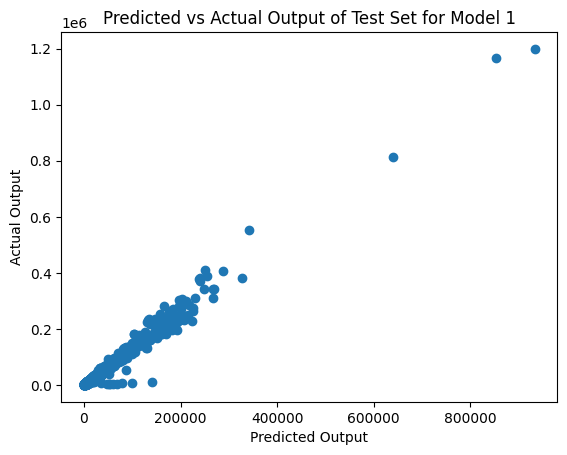

<ipython-input-123-24331137c199>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict1'] = model1.predict(test)


Text(0.5, 1.0, 'Predicted vs Actual Output of Test Set for Model 1')

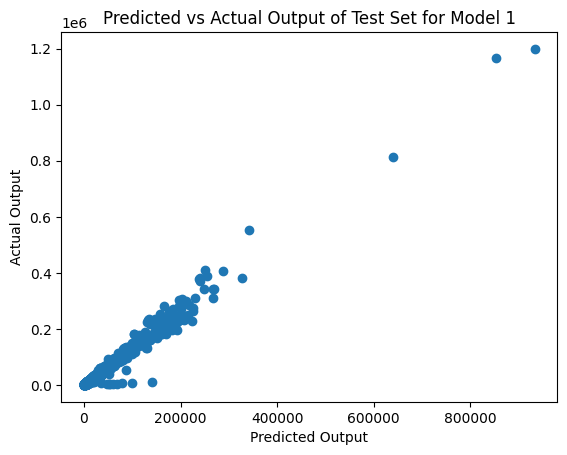

In [123]:
#plotting our model's predictions for projects' output in the test set against those projects' real values to see their correlation
test['predict1'] = model1.predict(test)
plt.scatter(test.predict1, test.ExpectedKWhAnnualProduction)
plt.xlabel("Predicted Output")
plt.ylabel("Actual Output")
plt.title("Predicted vs Actual Output of Test Set for Model 1")

In [124]:
##actual values versus predicted values
compare1 = pd.DataFrame(test[["predict1", "ExpectedKWhAnnualProduction"]])

In [125]:
test.corr().loc['predict1', 'ExpectedKWhAnnualProduction'] #super high correlation means this is a good model

<ipython-input-47-ff0c31a56235>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.corr().loc['predict1', 'ExpectedKWhAnnualProduction'] #super high correlation means this is a good model


0.9895097222629332

<ipython-input-125-ff0c31a56235>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.corr().loc['predict1', 'ExpectedKWhAnnualProduction'] #super high correlation means this is a good model


0.9895097222629332

<ipython-input-48-35cebe9c1884>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  byyear = DataEx.groupby(DataEx.DateCompleted.dt.year).sum().reset_index()


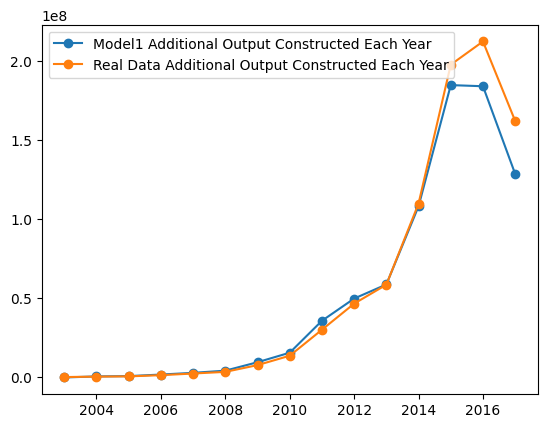

<ipython-input-126-35cebe9c1884>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  byyear = DataEx.groupby(DataEx.DateCompleted.dt.year).sum().reset_index()


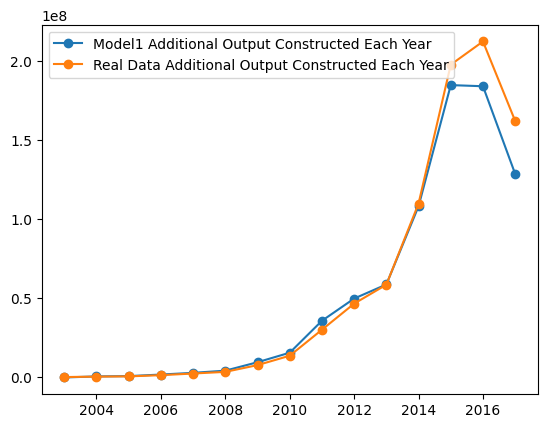

In [126]:
#based on the predictions from our model created by the train data set, validated by the test data set, this is the total predicted
#expected output per year
DataEx["OutputPrediction"]=model1.predict(DataEx)
byyear = DataEx.groupby(DataEx.DateCompleted.dt.year).sum().reset_index()
plt.plot(byyear.DateCompleted,byyear.OutputPrediction,  marker="o", label = "Model1 Additional Output Constructed Each Year")
#plt.title("Model1 Additional Output Constructed Each Year")

plt.plot(byyear.DateCompleted,byyear.ExpectedKWhAnnualProduction, marker="o", label = "Real Data Additional Output Constructed Each Year")
plt.legend()
plt.show()
#plt.title("Real Data Additional Output Constructed Each Year")
#compared to prediction graph above, the two are almost indistinguishable, so the model works pretty well on its own data


### We tried a different model, using both model2 and model3 to try and nest predictors for output that are correlated with each other to see if it was more accurate

In [127]:
# predicting cost based on pvmodulequantity because they are highly correlated
model_c =ols("ProjectCost~TotalPVModuleQuantity",train).fit()
train["cost_predict"] = model_c.predict(train[["TotalPVModuleQuantity"]])
test["cost_predict"] = model_c.predict(test[["TotalPVModuleQuantity"]])

<ipython-input-49-81d5c1f60d73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["cost_predict"] = model_c.predict(train[["TotalPVModuleQuantity"]])
<ipython-input-49-81d5c1f60d73>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["cost_predict"] = model_c.predict(test[["TotalPVModuleQuantity"]])
<ipython-input-127-81d5c1f60d73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Model 2 (using only a predicted cost_predicted)

In [128]:
#now running the model with cost_predict without ProjectCost, because ProjectCost is accounted for in cost_predict
model2 = ols("ExpectedKWhAnnualProduction ~ duration + cost_predict + Incentive", train).fit()
train['predict2'] = model2.predict(train[["cost_predict", "duration", "Incentive"]])
test["predict2"] = model2.predict(test[["cost_predict", "duration", "Incentive"]])
train.corr().loc['predict2', 'ExpectedKWhAnnualProduction']
#worse correlation, but still high

<ipython-input-50-7607bfde2efb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['predict2'] = model2.predict(train[["cost_predict", "duration", "Incentive"]])
<ipython-input-50-7607bfde2efb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predict2"] = model2.predict(test[["cost_predict", "duration", "Incentive"]])
<ipython-input-50-7607bfde2efb>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid 

0.9323865078507847

<ipython-input-128-7607bfde2efb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['predict2'] = model2.predict(train[["cost_predict", "duration", "Incentive"]])
<ipython-input-128-7607bfde2efb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predict2"] = model2.predict(test[["cost_predict", "duration", "Incentive"]])
<ipython-input-128-7607bfde2efb>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only val

0.9323865078507847

Text(0.5, 1.0, 'Predicted vs Actual Output of Test Set for Model 2')

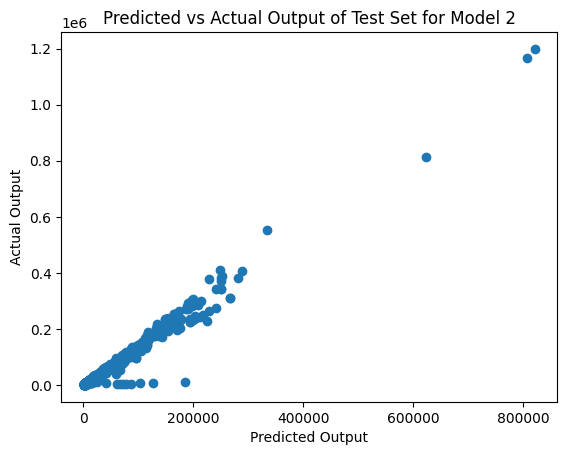

Text(0.5, 1.0, 'Predicted vs Actual Output of Test Set for Model 2')

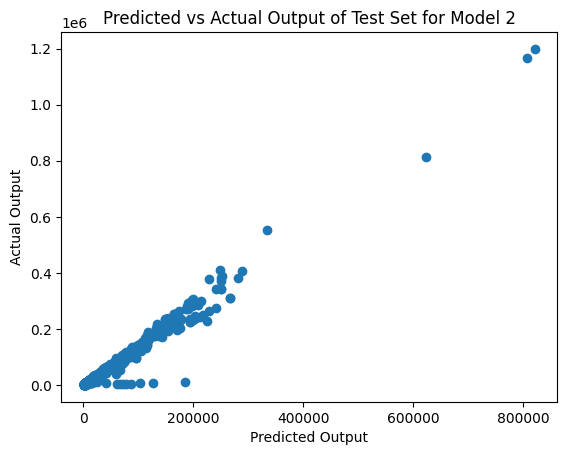

In [129]:
plt.scatter(test.predict2, test.ExpectedKWhAnnualProduction)
plt.xlabel("Predicted Output")
plt.ylabel("Actual Output")
plt.title("Predicted vs Actual Output of Test Set for Model 2")

In [130]:
compare2 = pd.DataFrame(test[["predict2", "ExpectedKWhAnnualProduction"]])

Making a Model 3 (with cost_predict and incentive_predict)

In [131]:
# predicting incentive based on cost_predict because they are correlated
model_i=ols("Incentive ~ cost_predict",train).fit()
train["incentive_predict"]= model_i.predict(train[["cost_predict"]])
test['incentive_predict'] = model_i.predict(test[["cost_predict"]])

<ipython-input-53-0ad3a176fc75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["incentive_predict"]= model_i.predict(train[["cost_predict"]])
<ipython-input-53-0ad3a176fc75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['incentive_predict'] = model_i.predict(test[["cost_predict"]])
<ipython-input-131-0ad3a176fc75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [132]:
#now running the model with incentive_predict without ProjectCost, because ProjectCost is accounted for in incentive_predict

model3 = ols("ExpectedKWhAnnualProduction~ duration + incentive_predict + previousyearavgoutput", train).fit()
test['predict3'] = model3.predict(test[["duration", "incentive_predict", "previousyearavgoutput"]])
test.corr().loc['predict3', 'ExpectedKWhAnnualProduction']


<ipython-input-54-9bbbf693fb2f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict3'] = model3.predict(test[["duration", "incentive_predict", "previousyearavgoutput"]])
<ipython-input-54-9bbbf693fb2f>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.corr().loc['predict3', 'ExpectedKWhAnnualProduction']


0.9892387914017943

<ipython-input-132-9bbbf693fb2f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict3'] = model3.predict(test[["duration", "incentive_predict", "previousyearavgoutput"]])
<ipython-input-132-9bbbf693fb2f>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.corr().loc['predict3', 'ExpectedKWhAnnualProduction']


0.9892387914017943

In [133]:
##actual values versus predicted values
compare3 = pd.DataFrame(test[["predict3", "ExpectedKWhAnnualProduction"]])

In [134]:
pd.concat([compare1[["ExpectedKWhAnnualProduction", "predict1"]], compare2[["predict2"]], compare3[["predict3"]]], axis=1)

,ExpectedKWhAnnualProduction,predict1,predict2,predict3
3,5758.0,4704.894275,5098.048753,4761.004354
22,13793.0,12107.024515,12757.916154,13122.906050
51,48080.0,41605.192312,34790.047611,35008.566892
67,5374.0,4755.207544,4732.320700,4471.159952
79,7248.0,100090.365123,126206.530876,132693.410783
...,...,...,...,...
74113,11198.0,9973.395831,10747.148729,10421.308832
74116,10576.0,9099.219848,10152.972024,9883.542285
74119,9643.0,8424.661625,9271.926276,9047.415879
74123,9332.0,8241.930066,9159.219260,8825.040109


,ExpectedKWhAnnualProduction,predict1,predict2,predict3
3,5758.0,4704.894275,5098.048753,4761.004354
22,13793.0,12107.024515,12757.916154,13122.906050
51,48080.0,41605.192312,34790.047611,35008.566892
67,5374.0,4755.207544,4732.320700,4471.159952
79,7248.0,100090.365123,126206.530876,132693.410783
...,...,...,...,...
74113,11198.0,9973.395831,10747.148729,10421.308832
74116,10576.0,9099.219848,10152.972024,9883.542285
74119,9643.0,8424.661625,9271.926276,9047.415879
74123,9332.0,8241.930066,9159.219260,8825.040109


Text(0.5, 1.0, 'Predicted vs Actual Output of Test Set for Model 3')

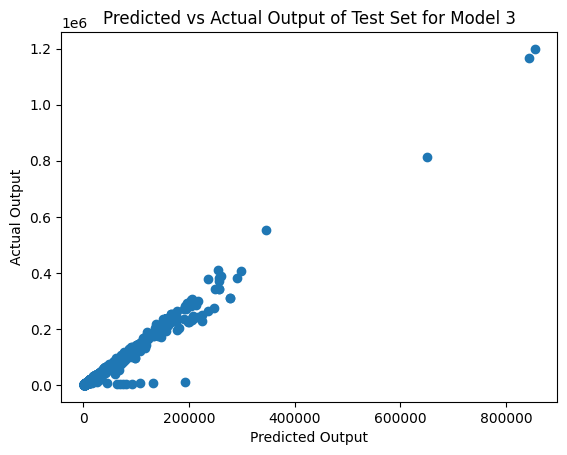

Text(0.5, 1.0, 'Predicted vs Actual Output of Test Set for Model 3')

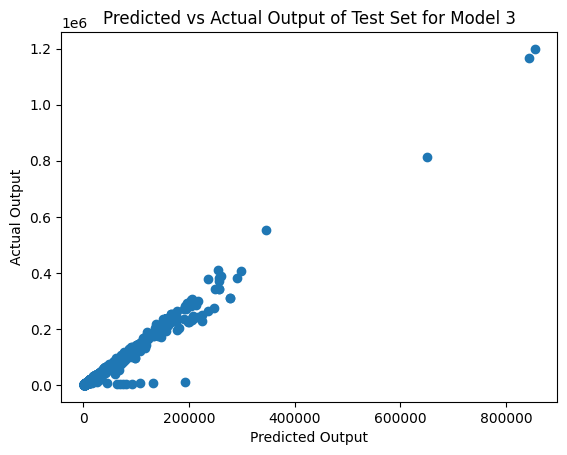

In [135]:
plt.scatter(test.predict3, test.ExpectedKWhAnnualProduction)
plt.xlabel("Predicted Output")
plt.ylabel("Actual Output")
plt.title("Predicted vs Actual Output of Test Set for Model 3")

In [136]:
prediction1 = test['predict1']
prediction2 = test['predict2']
prediction3 = test['predict3']

In [137]:
MSE1 =  mean_squared_error(test["ExpectedKWhAnnualProduction"], prediction1)
MSE2 =  mean_squared_error(test["ExpectedKWhAnnualProduction"], prediction2)
MSE3 =  mean_squared_error(test["ExpectedKWhAnnualProduction"], prediction3)
MSE1, MSE2, MSE3

(38099654.49398671, 46650767.29721333, 42513854.016383916)

(38099654.49398671, 46650767.29721333, 42513854.016383916)

In [138]:
##actual values versus predicted values
test[["predict3", "ExpectedKWhAnnualProduction"]]

,predict3,ExpectedKWhAnnualProduction
3,4761.004354,5758.0
22,13122.906050,13793.0
51,35008.566892,48080.0
67,4471.159952,5374.0
79,132693.410783,7248.0
...,...,...
74113,10421.308832,11198.0
74116,9883.542285,10576.0
74119,9047.415879,9643.0
74123,8825.040109,9332.0


,predict3,ExpectedKWhAnnualProduction
3,4761.004354,5758.0
22,13122.906050,13793.0
51,35008.566892,48080.0
67,4471.159952,5374.0
79,132693.410783,7248.0
...,...,...
74113,10421.308832,11198.0
74116,9883.542285,10576.0
74119,9047.415879,9643.0
74123,8825.040109,9332.0


End of testing different models ^^^

In [139]:
#seeing how duration correlates with time to decide if we should use time as a predictor for duration or hold it constant in our model for output
DataEx.corr().loc['t', 'duration'] #since it is a very small correlation, probably stays constant

<ipython-input-61-921d952805b9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataEx.corr().loc['t', 'duration'] #since it is a very small correlation, probably stays constant


-0.0974015402864255

<ipython-input-139-921d952805b9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataEx.corr().loc['t', 'duration'] #since it is a very small correlation, probably stays constant


-0.0974015402864255

In [140]:
model_duration = ols("duration~t", DataEx).fit()
display(model_duration.params)
durationintercept, beta_durationtime = model_duration.params

#beta_durationtime represents for every additional year, the expected duration of each project will decrease by 6.844049 DAYS OR YEARS? given all other factors remain constant IM CONFUSED BY THIS

Intercept    13969.699421
t               -6.844049
dtype: float64

Intercept    13969.699421
t               -6.844049
dtype: float64

In [141]:
#seeing how incentive correlates with time to decide if we should use time as a predictor for duration or hold it constant in our model for output
DataEx.corr().loc['t', 'Incentive'] #correlation is present

<ipython-input-63-7534f9f2e154>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataEx.corr().loc['t', 'Incentive'] #correlation is present


-0.3879178652657803

<ipython-input-141-7534f9f2e154>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataEx.corr().loc['t', 'Incentive'] #correlation is present


-0.3879178652657803

In [142]:
model_incentive = ols("Incentive~t", DataEx).fit() #using time to predict incentive
incentiveintercept, beta_incentivetime = model_incentive.params
model_incentive.params
#beta_incentivetime represents for every additional year, the expected incentive for each project will decrease 3189.212 dollars given all other factors remain constant

Intercept    6.433757e+06
t           -3.189212e+03
dtype: float64

Intercept    6.433757e+06
t           -3.189212e+03
dtype: float64

In [143]:
#seeing how project cost correlates with time to decide if we should use time as a predictor for duration or hold it constant in our model for output
DataEx.corr().loc['t', 'ProjectCost'] #correlation is present

<ipython-input-65-db96ebe3f98d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataEx.corr().loc['t', 'ProjectCost'] #correlation is present


-0.14046945334197053

<ipython-input-143-db96ebe3f98d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataEx.corr().loc['t', 'ProjectCost'] #correlation is present


-0.14046945334197053

In [144]:
model_cost = ols("ProjectCost~t", DataEx).fit() #using time to predict Project Cost
display(model_cost.params)
costintercept, beta_costtime = model_cost.params
#beta_incentivetime represents for every additional year, the expected incentive for each project will decrease 4,440.623 dollars given all other factors remain constant

Intercept    8.990813e+06
t           -4.440623e+03
dtype: float64

Intercept    8.990813e+06
t           -4.440623e+03
dtype: float64

In [145]:
#seeing how number of solar panels correlates with time to decide if we should use time as a predictor for duration or hold it constant in our model for output
DataEx.corr().loc['t', 'TotalPVModuleQuantity'] #very small correlation, probably stays constant

<ipython-input-67-d7fad2cf1dd6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataEx.corr().loc['t', 'TotalPVModuleQuantity'] #very small correlation, probably stays constant


-0.07120612285969904

<ipython-input-145-d7fad2cf1dd6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataEx.corr().loc['t', 'TotalPVModuleQuantity'] #very small correlation, probably stays constant


-0.07120612285969904

In [146]:
model_pv = ols("TotalPVModuleQuantity~t", DataEx).fit()
display(model_pv.params)
pvintercept, beta_pvtime = model_pv.params
#beta_pvtime represents for every additional year, the expected total pv module quantity decreases by 2.203106 units  given all other factors remain constant

Intercept    4475.386510
t              -2.203106
dtype: float64

Intercept    4475.386510
t              -2.203106
dtype: float64

Note on our 4 potentially time dependent variables above: we did test each of them against time squared as well, but the correlations were almost exactly the same but slightly lower on each so we just used time.

In [147]:
gtime = pd.date_range('1/1/2003', periods=15, freq='1Y').year #to be able to plot annual figures over time
gtime

Int64Index([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
            2014, 2015, 2016, 2017],
           dtype='int64')

Int64Index([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
            2014, 2015, 2016, 2017],
           dtype='int64')

Text(0.5, 1.0, 'Number of Projects Completed Each Year')

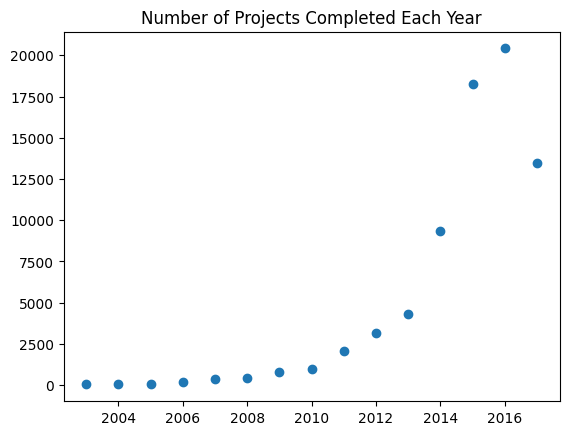

Text(0.5, 1.0, 'Number of Projects Completed Each Year')

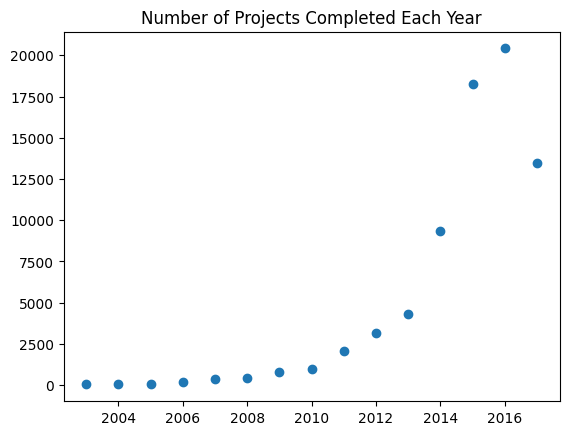

In [148]:
#groupedsum is the number of projects completed each year
groupedsum = grouped.size()
groupedsum
plt.scatter(gtime,groupedsum)
plt.title("Number of Projects Completed Each Year")
#now for each year, we predict what the value of each of the predictors would be (duration, cost, etc). then we use that to predict the
#output of a project finished that year. finally we multiply that by the number of projects we expect to be completed that year to get
#predicted additional output constructed that year

In [149]:
#adding an exponential time column to later use for an exponential regression
projectnum = pd.DataFrame(groupedsum).reset_index()
projectnum.columns = ['year', 'sum']
projectnum['year2'] = projectnum.year**2
projectnum

,year,sum,year2
0,2003,43,4012009
1,2004,98,4016016
2,2005,102,4020025
3,2006,210,4024036
4,2007,359,4028049
5,2008,429,4032064
6,2009,795,4036081
7,2010,974,4040100
8,2011,2088,4044121
9,2012,3158,4048144


,year,sum,year2
0,2003,43,4012009
1,2004,98,4016016
2,2005,102,4020025
3,2006,210,4024036
4,2007,359,4028049
5,2008,429,4032064
6,2009,795,4036081
7,2010,974,4040100
8,2011,2088,4044121
9,2012,3158,4048144


In [150]:
#doing an exponential regression for the sum total of projects using time and time squared
model_completed = ols("sum~year+year2", projectnum).fit()
completedintercept, beta_year, beta_year2 = model_completed.params
completed_function = (completedintercept + (beta_year * gtime) + (beta_year2*(gtime**2)))

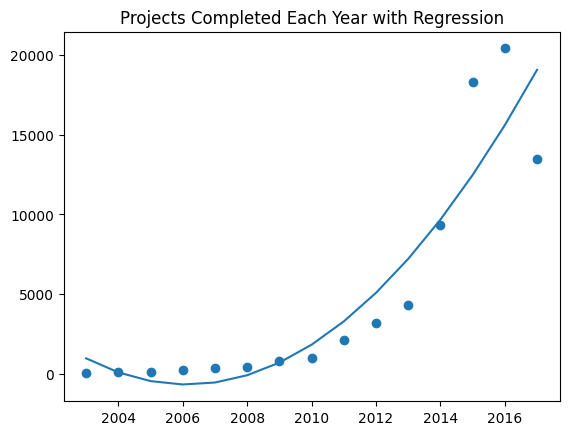

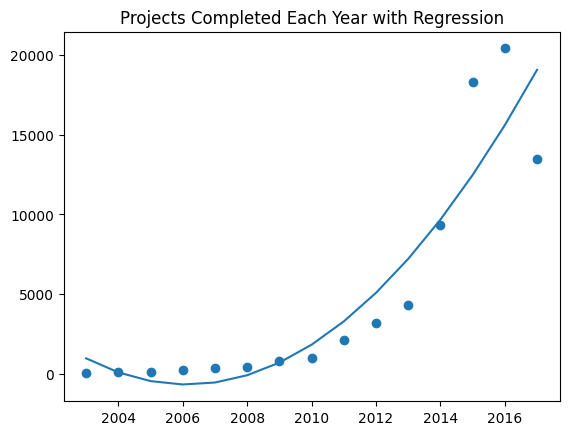

In [151]:
#graphing our regression on the same plot as the annual points
plt.scatter(gtime,groupedsum)
plt.plot(gtime, completed_function)
plt.title("Projects Completed Each Year with Regression")
plt.show()

In [152]:
#using the exponential regression to predict the number of completed projects in 2018 and 2019
expected_projects = [(completedintercept + (beta_year * 2018) + (beta_year2*(2018**2))), \
  (completedintercept + (beta_year * 2019) + (beta_year2*(2019**2)))]
expected_projects

[22874.11554837227, 27011.686977267265]

[22874.11554837227, 27011.686977267265]

In [153]:
#making variables for duration and number of panels since they remain constant
duration_constant = beta_duration*(DataEx.duration.mean())
pv_constant = beta_pv*(DataEx.TotalPVModuleQuantity.mean())

In [154]:
sampletime = [2018, 2019] #testing to see whether our model is good at predicting future years by predicting 2018 and 2019
sampleoutput = [12001.013930] #this is the average output from 2017, which would be considered the previous year's output in 2018
for i in sampletime:
    sampleoutput.append((mainintercept+ duration_constant + pv_constant + (beta_incentive*(incentiveintercept + (beta_incentivetime * i)))\
                        + (beta_cost*(costintercept + (beta_costtime * i))) + (beta_previous*sampleoutput[-1]))) #using beta values from model1, and time dependent beta values for cost and incentive

output_predicted = sampleoutput[1:] #dropping the 2017 value which will be accounted for when we sum the output from 2003-2017
sampleoutput
output_predicted

[9931.60698444511, 9130.41910459393]

[9931.60698444511, 9130.41910459393]

In [155]:
#predicted values for total additional output in 2018 and 2019 by multiplying the number of predicted projects by the predicted output of each of those projects
newyears = pd.Series(output_predicted) * pd.Series(expected_projects)
newyears

0    2.271767e+08
1    2.466280e+08
dtype: float64

0    2.271767e+08
1    2.466280e+08
dtype: float64

In [156]:
#total output per year at the end of 2017, converting from annual KW to MW
Output_pre_2018 = byyear.ExpectedKWhAnnualProduction.sum()
Output_pre_2018KW = Output_pre_2018/(365*24)
Output_pre_2018MW = Output_pre_2018KW/1000
print("Total output at the end of 2017:", Output_pre_2018MW, 'MW')

Total output at the end of 2017: 96.72536929223745 MW
Total output at the end of 2017: 96.72536929223745 MW


In [157]:
total = byyear.ExpectedKWhAnnualProduction.sum() + newyears[0] + newyears[1] #adding output sun from 2003-2017 to expected additional output in 2018 and 2019
total = total/(365*24*1000)
print("Total predicted output at the end of 2019:", total, "MW")

Total predicted output at the end of 2019: 150.81266935705142 MW
Total predicted output at the end of 2019: 150.81266935705142 MW


This shows that even though the average output of a single project is decreasing over time, the number of projects is increasing much faster, so NY's solar construction is continuing to accelerate